In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [43]:
train_dataset = pd.read_csv('titanic-train.csv')
test_dataset = pd.read_csv('titanic-test.csv')

In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_dataset['Sex'])
train_dataset['Sex_Labels'] = le.transform(train_dataset['Sex'])
test_dataset['Sex_Labels'] = le.transform(test_dataset['Sex'])
train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Labels
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1


In [49]:
train_dataset['Cabin_Available']=train_dataset['Cabin'].isna().apply(int)
test_dataset['Cabin_Available']=test_dataset['Cabin'].isna().apply(int)

In [50]:
train_dataset.fillna('Null')
test_dataset.fillna('Null')

le = LabelEncoder()
le.fit(train_dataset['Embarked'])
train_dataset['Embarked_Labels'] = le.transform(train_dataset['Embarked'])
test_dataset['Embarked_Labels'] = le.transform(test_dataset['Embarked'])

In [51]:
train_dataset['Age_Available']=train_dataset['Age'].isna().apply(int)
test_dataset['Age_Available']=test_dataset['Age'].isna().apply(int)

train_dataset['Age'] = train_dataset['Age'].fillna(train_dataset.groupby('Sex')['Age'].transform('mean'))
test_dataset['Age'] = test_dataset['Age'].fillna(test_dataset.groupby('Sex')['Age'].transform('mean'))

In [52]:
train_sex = train_dataset['Sex']
test_sex = test_dataset['Sex']
train_embarked = train_dataset['Embarked']
test_embarked = test_dataset['Embarked']

train_dataset.drop(['PassengerId','Sex','Cabin','Ticket','Embarked'],axis=1,inplace=True)
test_dataset.drop(['PassengerId','Sex','Cabin','Ticket','Embarked'],axis=1,inplace=True)
test_dataset.dropna(inplace=True)
train_dataset.dropna(inplace=True)

<AxesSubplot:>

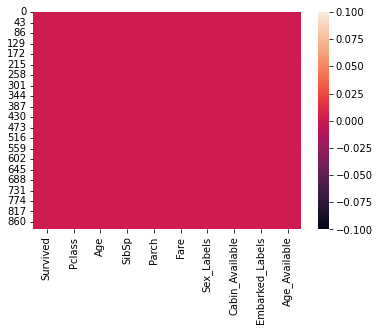

In [53]:
sns.heatmap(train_dataset.isnull())

<AxesSubplot:>

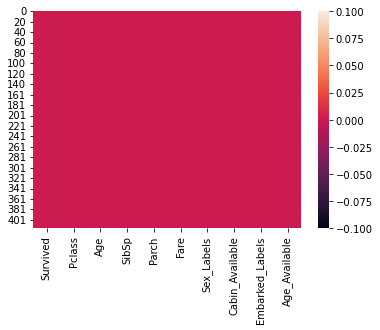

In [54]:
sns.heatmap(test_dataset.isnull())

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_dataset.drop(['Survived'], inplace=False, axis=1), train_dataset['Survived'], test_size=0.20, random_state=42)

### Information Gain from each Split

In [70]:
# create node class to store splits within out tree
# these will be used for prediction later
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left= left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

In [71]:
class DecisionTree:
    # initialize class with depth and min splits
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    # check if tree is finished when max depth is reached
    # or we have only one class label in one split
    # or number of samples created is less than the minimum samples from each split
    def _is_finished(self, depth):
        if (depth>=self.max_depth or 
            self.n_class_labels == 1 or
            self.n_samples < self.min_samples_split):
            return True
        return False
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))
        
        # check for stopping criteria
        # if true then find most frequent label in current split
        # return Leaf Node with that label as its value
        if self._is_finished(depth):
            most_common_label = np.argmax(np.bincount(y))
            return Node(value=most_common_label)
        
        # get best split
        random_features = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feature, best_threshold = self._best_split(X, y, random_features)
        
        # grow children recursively
        left_idx, right_idx = self._create_split(X[:, best_feature], best_threshold)
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth+1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth+1)
        return Node(best_feature, best_threshold, left_child, right_child)
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y)
    
    def _entropy(self, y):
        proportions = np.bincount(y)/len(y)
        entropy = -np.sum([p*np.log2(p) for p in proportions])
        return entropy
    
    def _create_split(self, X, threshold):
        left_idx = np.argwhere(X <= threshold).flatten()
        right_idx = np.argwhere(X > threshold).flatten()
        return left_idx, right_idx
    
    # calculate information gain by subtracting the entropy of parent and children
    # loss obtained from the entropy
    def _information_gain(self, X, y, threshold):
        parent_loss = self._entropy(y)
        left_idx, right_idx = self._create_split(X, threshold)
        n, n_left, n_right = len(X), len(left_idx), len(right_idx)
        
        if n_left==0 or n_right==0:
            return 0
        
        child_loss = (n_left/n)*self._entropy(y[left_idx]) + (n_right/n)*self._entropy(y[right_idx])
        return parent_loss - child_loss
    
    # finding best split in parent dataset
    def _best_split(self, X, y, features):
        # dictionary to track splits
        split = {'score':-1, 'feature':None, 'threshold':None}
        
        # loop over features in parent to find best split
        for feature in features:
            # subset over the feature
            X_feat = X[:, feature]
            # find possible thresholds in that feature column
            thresholds = np.unique(X_feat)
            # loop over possible thresholds and check information gain
            # if the best improvement then update split data
            for threshold in thresholds:
                score = self._information_gain(X_feat, y, threshold)
                if score > split['score']:
                    split['score']=score
                    split['feature']=feature
                    split['threshold']=threshold
        
        # return the best split
        return split['feature'], split['threshold']
    
    # create functions for predictions
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [81]:
def get_accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [75]:
model = DecisionTree(max_depth=3)

In [76]:
model.fit(np.array(X_train), np.array(y_train))

C:\Users\Kathik\AppData\Local\Temp/ipykernel_17832/1568819582.py:44: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum([p*np.log2(p) for p in proportions])
C:\Users\Kathik\AppData\Local\Temp/ipykernel_17832/1568819582.py:44: RuntimeWarning: invalid value encountered in double_scalars
  entropy = -np.sum([p*np.log2(p) for p in proportions])


In [78]:
y_pred = model.predict(np.array(X_test))

In [82]:
accuracy = get_accuracy(np.array(y_test), y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7932960893854749
